# CRM End Term Project

- Problem statement: To simulate a PFR based on the given conditions.

- Assumptions made during modeling:
1. We are assuming an ideal PFR.
2. Steady state conditions are applicable.
3. No gas phase reactions are occuring(only dealing with the Surface reactions).
4. The PFR is in isothermal conditions.

### Importing the required libraries

In [29]:
# 1. ODE solver
using DifferentialEquations

# 2. For plotting
using Plots; gr()

Plots.GRBackend()

In [30]:
# Numerical representations for species
    #     1 -> CH4
    #     2 -> H20
    #     3 -> CO
    #     4 -> H2
    #     5 -> He

# Respective Molecular weights (in kg/mol)
Mol_Wts = [16E-3, 18E-3, 28E-3, 2E-3, 4E-3]

# Parameters and variables used:

# Gas constant(R) in J/mol.K
R = 8.314

# Activation energy (Steam reforming of methane)
E =280.944

# Diameter of the PFR (in m)
D = 1E-2      

# Length of the PFR (in m)
L = 2.7E-2   

# Volumetric flow rate (in m^3/sec)
Q = (4E-3)/60    

# Cross sectional area  (in m^2)
Ac = (π*D^2)/4

# catalytic surface area factor
γ = 0.7    # Guess value 

# pre-exponential factor
k0_r = 3.5E-9      # Guess value 

# Surface area to length ratio
A_SL = γ*(π*D)

P = 101325  #  (in Pa)

# Initial mole fractions
X0 =  [1.6E-2, 2E-2, 0, 0, 96.4E-2]

# Initial avg. molecular weight  (OR avg. molecular weight at the inlet)
M_avg0  = sum(Mol_Wts.*X0)

# Initial mass fractions
Y0_CH4 = X0[1]*Mol_Wts[1]/M_avg0
Y0_H20 = X0[2]*Mol_Wts[2]/M_avg0
Y0_C0 = X0[3]*Mol_Wts[3]/M_avg0
Y0_H2 = X0[4]*Mol_Wts[4]/M_avg0
Y0_He = X0[5]*Mol_Wts[5]/M_avg0
Y0 = [Y0_CH4, Y0_H20, Y0_C0, Y0_H2, Y0_He]

# Temp (in K)
T = 1173  

# Product of density and velocity
ρu = (P*M_avg0/(R*T))*(Q/Ac)    # will remain constant throughout for a particular temperature    

#Eqm constants (at 3 different temperatures) calculated from NASA polynomials
K_R = Dict(973  => 1.41138e13,
        1073 => 1.55414e13,
        1173 => 1.63184e13)

Dict{Int64, Float64} with 3 entries:
  973  => 1.41138e13
  1173 => 1.63184e13
  1073 => 1.55414e13

### Function for converting mass fracn to mole fraction
where,
- Yk= vector containing the mass fractions of the species
- returns Xk(vector containing the mol fractions of the species)

In [31]:
function mass_to_molfracn(Yk)
    one_by_M = [1/i for i in Mol_Wts]    # Reciprocal of mol wts
    n_total = sum(one_by_M.*Yk)
    
    Xk = [(Yk[i]/Mol_Wts[i])/n_total for i in range(1,length = length(Yk))] 
end

mass_to_molfracn (generic function with 1 method)

### Function for Governing Equation

where, 
- dY[1] = Rate of change of mass fraction of CH4 with respect to the distance along the reactor

In [32]:
function governing_eqn(dY,Y,p,t)
    k_R1 = k0_r*exp(-E/(R*T))
    K_R1 = K_R[T]
    
    X_CH4, X_H20, X_CO, X_H2, X_He = mass_to_molfracn(Y)
    rate = k_R1*( X_CH4*X_H20*P^2 - ((X_CO*(X_H2^3))*P^4)/K_R1 )

    dY[1] =  -rate*Mol_Wts[1]*(A_SL/Ac)*(1/ρu)
    dY[2] =  -rate*Mol_Wts[2]*(A_SL/Ac)*(1/ρu)
    dY[3] =  rate*Mol_Wts[3]*(A_SL/Ac)*(1/ρu)
    dY[4] =  3*rate*Mol_Wts[4]*(A_SL/Ac)*(1/ρu)
    dY[5] =  0
end

governing_eqn (generic function with 1 method)

### Modeling the PFR
- returns the mol fraction at the outlet and plots the variation of mol fractions with respect to the distance along the reactor

In [33]:
function pfr_simulation(L,D,γ,E,k0_r,Q,P,T,X0,Mol_Wts)
    Ac = (π*D^2)/4
    A_SL = γ*(π*D)
    M_avg0  = sum(Mol_Wts.*X0)
    ρu = (P*M_avg0/(R*T))*(Q/Ac)    # will remain constant throughout for a particular temperature    
    xspan = (0,L)
    prob = ODEProblem(governing_eqn,Y0,xspan)
    sol = solve(prob)
    println(100*mass_to_molfracn(sol.u[end])) # Returns the mole fractions at the outlet
    plot(sol)    
end

pfr_simulation (generic function with 1 method)

### Calling the above function

[0.9717462776782281, 1.3668760937842606, 0.6087729867459034, 1.8263189602377106, 95.2262856815539]


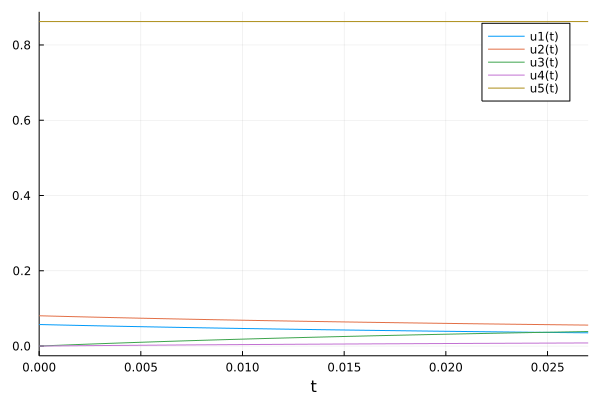

In [34]:
pfr_simulation(L,D,γ,E,k0_r,Q,P,T,X0,Mol_Wts)

# References
### Keq calculations using NASA polynomials (used Assignment2 )

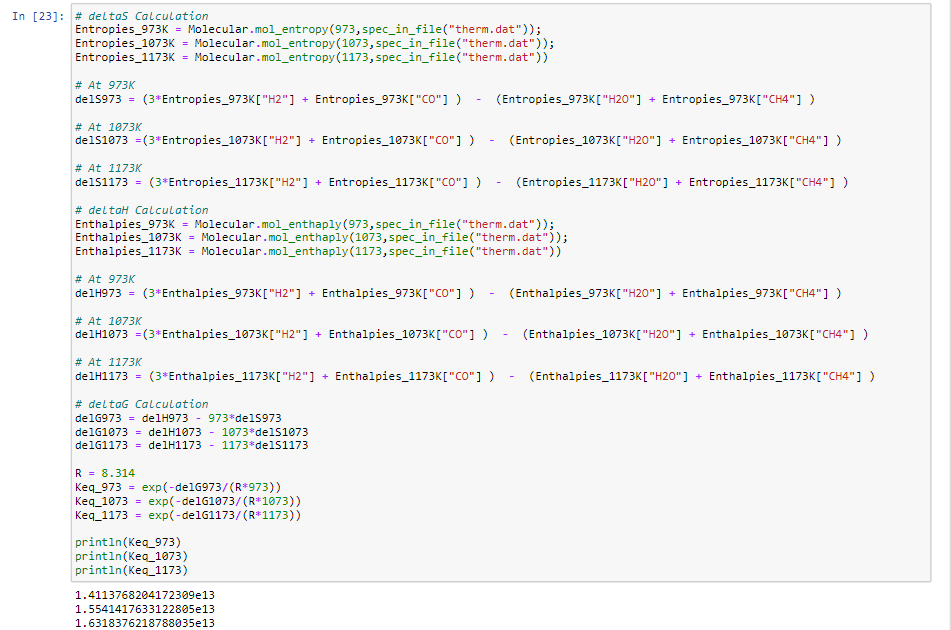